# Medical Image Analysis project : methods implementation

In the following code, we present an implementation of the sequential and iterative reconstruction/registration methods based on the original paper cited in README. We also focus on the non-rigid B-Spline transformation and its effect on a 3D Shepp-Logan phantom.

### Packages loading (main ones : TomoPy and SimpleITK)

In [3]:
import scipy
import random
import numpy as np
import tomopy as tmpy
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.interpolate as griddata
import warnings
warnings.filterwarnings("ignore")

### Visualization of the ground-truth Image :  $f_1$

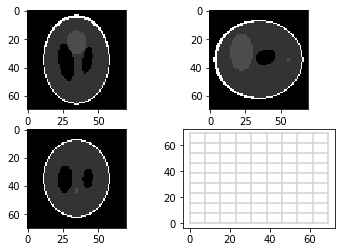

In [21]:
### grid generation
def plot_grid(ax, gridx,gridy, **kwargs):
    for i in range(gridx.shape[0]):
        ax.plot(gridx[i,:], gridy[i,:], **kwargs)
    for i in range(gridx.shape[1]):
        ax.plot(gridx[:,i], gridy[:,i], **kwargs)

### data Transverse, Sagittal and Coronal views and grid visualization
def data_viz(data,M,N,m,XX_grid,YY_grid):
    H_transverse = data[M,:,:] 
    H_sagittal = data[:,M,:]
    H_coronal = data[:,:,M]
    fig = plt.figure()
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    im_transverse = ax0.imshow(H_transverse, cmap='gray', interpolation='none')
    im_coronal = ax1.imshow(H_coronal, cmap='gray', interpolation='none')
    im_sagittal = ax2.imshow(H_sagittal, cmap='gray', interpolation='none')
    plot_grid(ax3,XX_grid,YY_grid, color="lightgrey")
    plt.show()

### results
N = 70 #data size
M = 32 #view index
m = 10 #number of samples on grid data
coordsX = np.linspace(0,N-1,m)
coordsY = np.linspace(0,N-1,m)
XX_grid, YY_grid = np.meshgrid(coordsX, coordsY)
data = tmpy.misc.phantom.shepp3d(size=N, dtype=u'float32') # ground-truth data
data_viz(data,M,N,m,XX_grid,YY_grid)

### Effects of B-Spline on a 2D regular grid

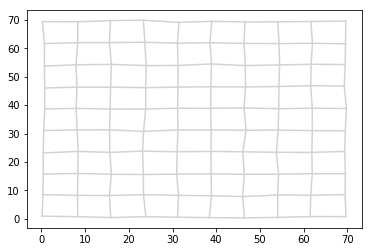

In [15]:
def b_spline_2D_grid_transform(distXX_2D,distYY_2D,XX_grid,YY_grid,m):
    # meta-parameters of the transformation
    dimension = 2
    spline_order = 1
    direction_matrix_row_major = [1,0.0,0.0,1.0] 
    origin = [0,0]  
    domain_physical_dimensions = [N,N]
    bspline = sitk.BSplineTransform(dimension, spline_order)
    bspline.SetTransformDomainOrigin(origin)
    bspline.SetTransformDomainDirection(direction_matrix_row_major)
    bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
    bspline.SetTransformDomainMeshSize((N,N))
    # Random displacement of the control points (transformation parameters)
    len_params = len(bspline.GetParameters())
    originalControlPointDisplacements = np.random.random(len_params)
    bspline.SetParameters(originalControlPointDisplacements)
    # transformation
    for i in range(0,m):
        for j in range(0,m):
            point = [XX_grid[i,j],YY_grid[i,j]]
            l = list(bspline.TransformPoint(point))
            distXX_2D[i,j], distYY_2D[i,j] = l[0], l[1] 
    return distXX_2D, distYY_2D

# generation
m = 10
distXX_2D = np.zeros(shape=(m,m))
distYY_2D = np.zeros(shape=(m,m))
coordsX = np.linspace(0,N-1,m)
coordsY = np.linspace(0,N-1,m)
XX_grid, YY_grid = np.meshgrid(coordsX, coordsY)
distXX_2D, distYY_2D = b_spline_2D_grid_transform(distXX_2D,distYY_2D,XX_grid,YY_grid,m)

# visualization
fig, ax = plt.subplots()
plot_grid(ax,distXX_2D,distYY_2D, color="lightgrey")
plt.show()

### B-Spline on a 3D regular grid

In [17]:
def b_spline(dat,params) : 
    dimension = 3
    spline_order = 1
    direction_matrix_row_major = [1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0] 
    origin = [0,0,0]  
    domain_physical_dimensions = [N,N,N]
    bspline = sitk.BSplineTransform(dimension, spline_order)
    bspline.SetTransformDomainOrigin(origin)
    bspline.SetTransformDomainDirection(direction_matrix_row_major)
    bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
    bspline.SetTransformDomainMeshSize((N,N,N))
    # Random displacement of the control points.
    originalControlPointDisplacements = params
    bspline.SetParameters(originalControlPointDisplacements)
    coordsX = np.linspace(0,N-1,N)
    coordsY = np.linspace(0,N-1,N)
    coordsZ = np.linspace(0,N-1,N)
    XX, YY, ZZ = np.meshgrid(coordsX, coordsY, coordsZ)
    distXX = np.ones(shape=(N,N,N))
    distYY = np.ones(shape=(N,N,N))
    distZZ = np.ones(shape=(N,N,N))
    for i in range(0,N):
        for j in range(0,N):
            for k in range(0,N):
                point = [XX[i,j,k],YY[i,j,k],ZZ[i,j,k]]
                l = list(bspline.TransformPoint(point))
                distXX[i,j,k], distYY[i,j,k], distZZ[i,j,k] = l[0], l[1], l[2] 
    interp_vals = scipy.interpolate.griddata((np.ravel(distXX).T,np.ravel(distYY).T,np.ravel(distZZ).T), np.ravel(data).T, (XX,YY,ZZ), 'linear')
    interp_vals = np.nan_to_num(interp_vals)
    return interp_vals

# Transformed Data after BSpline + trilinear interpolation
len_params = 3*(N+1)**3 #total number of parameters
params_init = np.random.random(len_params)
interp_vals = b_spline(data,params_init)

### Visualization of transformed Image : $f_2 = T_{\theta}(f_1)$
Changes can be well noticed on the black shape of the Sagittal view (right above)

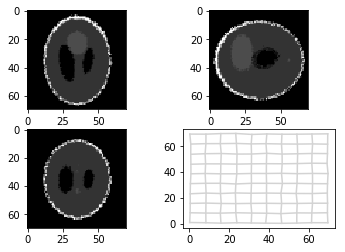

In [22]:
data_viz(interp_vals,M,N,m,distXX_2D, distYY_2D)

### Projections generation : $p_1$ and $p_2$

In [24]:
# projections
nang = 11 #number of projections
angles_proj = tmpy.sim.project.angles(nang, ang1=-25.0, ang2=25.0) #rangle of angles projections
center = 0.5*np.array(data.shape)
p1 = tmpy.sim.project.project(data, angles_proj, center=center, pad=False) # p1
p2 = tmpy.sim.project.project(interp_vals, angles_proj, center=center, pad=False) #p2

### Visualizations of projections

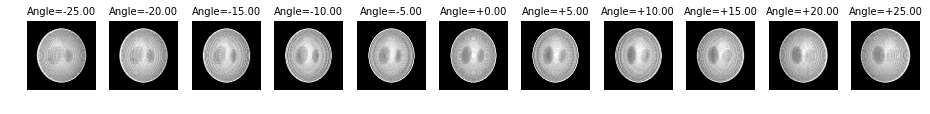

In [26]:
plt.figure(figsize=(16,4))
for i in range(11):
    plt.subplot(2, 11, i+1)
    plt.imshow(p1[i,:,:], cmap='gray')
    plt.title("Angle={:+.2f}".format(-25 + i*(50/10)), fontsize=10)
    plt.axis('off')
plt.show()

### Generation of $A^{T}p$ i.e. $f$ such that $p = Af$ by "naive" reconstruction

In [28]:
# rotation in 3D
def rotation_matrix(angle, axis='x'):
    if axis=='x':
        rot = np.array([[1, 0, 0],
                        [0, np.cos(angle), -np.sin(angle)],
                        [0, np.sin(angle), np.cos(angle)]])
    elif axis=='y':
        rot = np.array([[np.cos(angle), 0, -np.sin(angle)],
                        [0, 1, 0],
                        [np.sin(angle), 0, np.cos(angle)]])
    else:
        rot = np.array([[np.cos(angle), -np.sin(angle), 0],
                        [np.sin(angle), np.cos(angle), 0],
                        [0, 0, 1]])
    return rot

#affine transformation
def affine_transformation(f, angle, translation, axis='x', order=3):
    
    # Rotation matrix
    rot = rotation_matrix(angle, axis)
        
    # Compute rotation center (center of volume)
    center = 0.5*np.array(f.shape)
    offset=-(center-center.dot(rot)).dot(np.linalg.inv(rot))

    # Compute transformation (along with interpolation)
    out = scipy.ndimage.affine_transform(f,rot, offset=offset)
    # Binarize output
    #out[out>0.90] = 1.0
    #out[out<=0.90] = 0.0
    
    out = scipy.ndimage.affine_transform(out, np.eye(3), offset=translation, order=order)
    
    return(out)

#generation of A.T(p)
def backward_projection(p):
    n, d = p.shape[0], p.shape[1]
    back = np.zeros((d, d, d))
    # Rotation center
    center = 0.5*np.array(back.shape)
    for i in range(n):
        # Compute expanded projection
        proj = np.expand_dims(p[i], axis=2)
        expanded_proj = np.tile(proj, d)
        # Compute associated rotation
        angle = -25 + i*(50/10)
        angle = (angle/360)*2*np.pi
        rot = rotation_matrix(angle, axis='x')
        offset=-(center-center.dot(rot)).dot(np.linalg.inv(rot))
        expanded_proj = scipy.ndimage.affine_transform(expanded_proj, rot, offset=offset)
        back += (1/n) * expanded_proj
    return back

### Simple reconstruction method (used in sequential approach)

In [30]:
def rescale_array(f):
    min_f, max_f = np.min(f), np.max(f)
    return (f - min_f)/(max_f - min_f)

# gradient descent returning reconstructed image + cost
def recon_grad_descent(p, stepsize=1e-2, tol=1e-2, max_iter=100,
                       angles=tmpy.sim.project.angles(11, ang1=-25.0, ang2=25.0),
                       init=None):
    # Parameters
    n, d = p.shape[0], p.shape[1]
    # Initialization
    if init is not None:
        f = init
    else:
        f = np.zeros((N,N,N))
    it = 0
    cost = []
    # Repeat until convergence
    while it<max_iter:
        proj = tmpy.sim.project.project(f, angles, center=0.5*np.array(f.shape), pad=False)
        criterion = np.linalg.norm( proj - p )
        cost.append(criterion)
        if criterion<tol:
            break
        else:
            f = f - stepsize * backward_projection( proj - p )
            it += 1
    
    return rescale_array(f), cost

f1_rec, cost1 = recon_grad_descent(p1, stepsize=1e-3, tol=1e-2, max_iter=20)
f1_rec = rescale_array(f1_rec)

### Visualizations of reconstructions :  $\hat{f}_{1,seq} = A^{T}p_1$

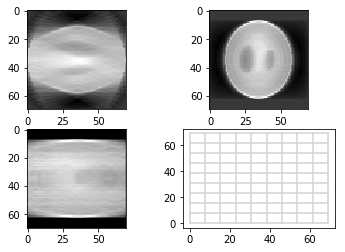

In [31]:
data_viz(f1_rec,M,N,m,XX_grid,YY_grid)

### Cost graph during $f_1$ reconstruction

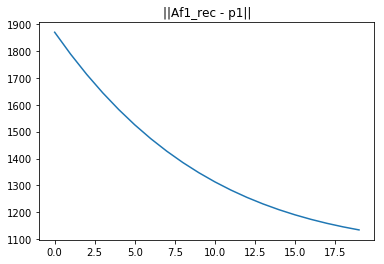

In [32]:
plt.plot(cost1)
plt.title('||Af1_rec - p1||')
plt.show()

### Visualizations of error : $ || \hat{f}_1 - f_1||$

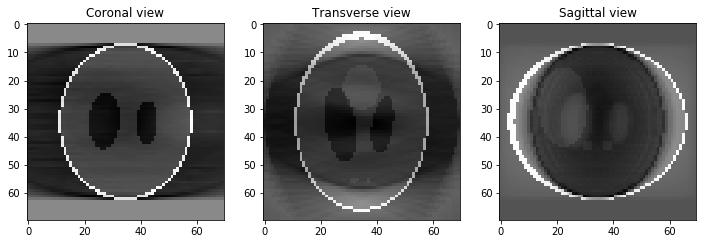

In [44]:
def plot_volume(f, d=N):
    plt.figure(figsize=(12,4))
    plt.subplot("131")
    plt.title("Coronal view")
    plt.imshow(f[:,d//2,:], cmap='gray')
    plt.subplot("132")
    plt.title("Transverse view")
    plt.imshow(f[d//2,:,:], cmap='gray')
    plt.subplot("133")
    plt.title("Sagittal view")
    plt.imshow(f[:,:,d//2], cmap='gray')
    plt.show()
    
plot_volume(data - f1_rec)

### Visualizations of reconstruction :  $\hat{f}_{2,seq} = A^{T}p_2$

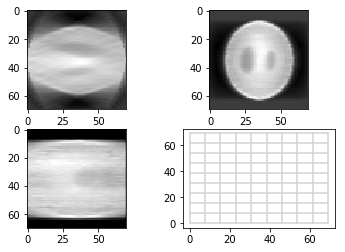

In [34]:
f2_rec, cost2 = recon_grad_descent(p2, stepsize=1e-3, tol=1e-2, max_iter=20)
f2_rec = rescale_array(f2_rec)
data_viz(f2_rec,M,N,m,XX_grid,YY_grid)

### cost graph during $f_2$ reconstruction

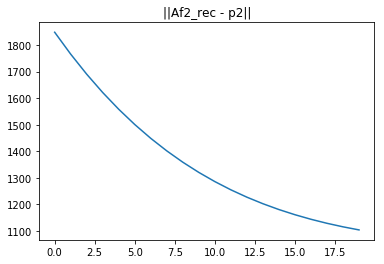

In [35]:
plt.plot(cost2)
plt.title('||Af2_rec - p2||')
plt.show()

### Visualizations of error : $ || \hat{f}_2 - f_2||$

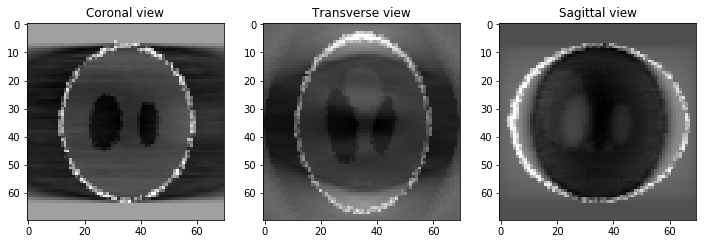

In [45]:
plot_volume(interp_vals - f2_rec)

### Simple registration method (used in sequential approach)

In [38]:
def cost_registration(f1, f2, params):
    return 0.5*np.linalg.norm(f2 - b_spline(f1,params))**2

len_params = 3*((N+1)**3)
eps = 1e-3
epsilon = np.array([eps]*len_params)

def transformation_gradient(f1, f2, params, epsilon):
    # Params
    dcost_angle = (cost_registration(f1, f2, params+epsilon) - cost_registration(f1, f2, params-epsilon))/(2*np.linalg.norm(epsilon)**2)

    return dcost_angle

def registration_grad_descent(f1, f2, stepsize=1e-4, tol=1e-3, max_iter=7, init_params=None):
    # Initialization
    if init_params is not None:
        params = init_params
    else:
        np.random.seed(5)
        params = np.random.random(len_params)
    it = 0
    cost = []
    # Repeat until convergence
    while it<max_iter:
        criterion = cost_registration(rescale_array(f1), rescale_array(f2), params)
        cost.append(criterion)       
        if criterion<tol:
            break
        else:
            grad = transformation_gradient(rescale_array(f1), rescale_array(f2), params, epsilon)
            params = params - stepsize * params
            it += 1
    
    return params, cost

### Iterative reconstruction and registration method

In [39]:
def iterative_recon_reg(p1, p2, k=3, stepsize_recon=1e-3, iter_recon=3, stepsize_reg=1e-6):
    # Initialization
    n, d = p1.shape[0], p1.shape[1]
    f1, f2 = np.zeros((N,N,N)), np.zeros((N,N,N))
    init_params = np.random.random(len_params)
    
    for i in range(k):
        # j steps of reconstruction (j = iter_recon)
        f1, _ = recon_grad_descent(p1, stepsize=stepsize_recon, max_iter=iter_recon,init=f1)
        f1 = rescale_array(f1)
        f2, _ = recon_grad_descent(p2, stepsize=stepsize_recon, max_iter=iter_recon,init=f2)
        f2 = rescale_array(f2)
        # registration step
        params, _ = registration_grad_descent(f1_rec, f2_rec, max_iter=5, stepsize=5e-6,
                                                          init_params=init_params)
        # change f2 for its registered version
        f2 = b_spline(f1,params)
        f2 = rescale_array(f2)
        
    return f1, f2, params

f1_rec_iter, f2_rec_iter, params_iter = iterative_recon_reg(p1, p2,
                                                                             k=4, stepsize_recon=1e-4,
                                                                             iter_recon=4, stepsize_reg=1e-4)

### Visualizations of reconstruction :  $\hat{f}_{1,iter} = A^{T}p_1$

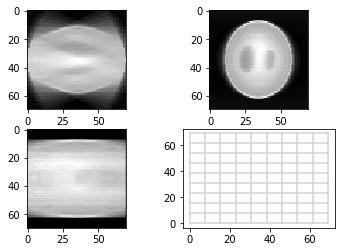

In [40]:
data_viz(f1_rec_iter,M,N,m,XX_grid,YY_grid)

### Visualizations of reconstruction :  $\hat{f}_{2,iter} = A^{T}p_2$

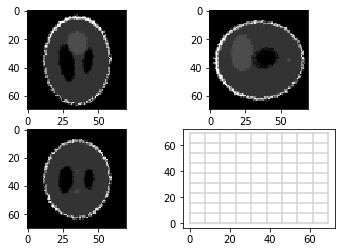

In [41]:
data_viz(f2_rec_iter,M,N,m,XX_grid,YY_grid)

### Visualizations of error : $ || \hat{f}_{1,iter} - f_1||$

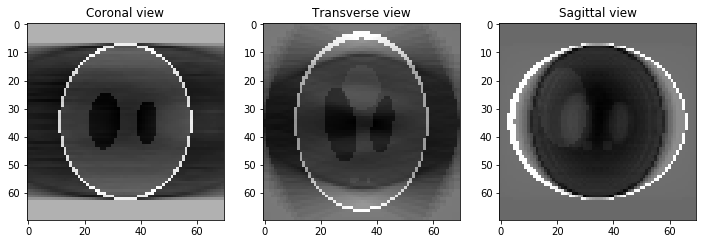

In [42]:
plot_volume(data - f1_rec_iter)

### Visualizations of error : $ || \hat{f}_{2,iter} - f_2||$

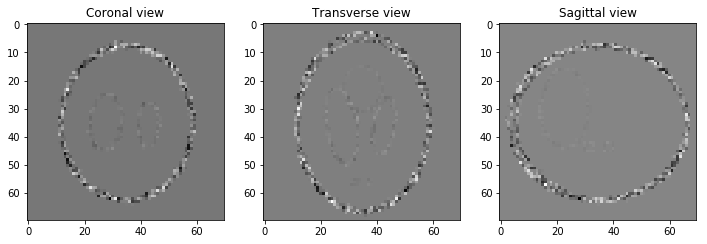

In [43]:
plot_volume(interp_vals - f2_rec_iter)